# Pilot GWAS
Pilot GWAS for 800 cord blood samples (692 after filtering) carried out in Hail.

In [1]:
import hail as hl
hl.init()

Running on Apache Spark version 2.4.1
SparkUI available at http://ip164-74.pool1.hus-b.bmc.lu.se:4042
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.60-de1845e1c2f6
LOGGING: writing to /home/antton/TFM/scripts/GWAS/hail-20210610-1650-0.2.60-de1845e1c2f6.log


In [2]:
from hail.plot import show
from pprint import pprint
import numpy as np

hl.plot.output_notebook()

Loading BokehJS ...

In [3]:
#Function used to re-order indexes based on natural ordering

import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

## Import data from separate bgens
Import genotype data from BGEN format files. There's one per each chromosome. The files are then indexed in Hail. All of the information of the files will be put in a Hail MatrixTable object simply named 'mt'.

In [4]:
from os import listdir
from os.path import isfile, join

#Path to sample file
sample_path = '/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/Sweden_CordBlood_wAliases_201130_ID2first.sample'
#Main folder with all .BGEN files. 
path_to_bgens = '/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/bgens'
#List of individual file paths
bgen_paths_list = [path_to_bgens+'/'+f for f in listdir(path_to_bgens) if isfile(join(path_to_bgens, f)) and f.endswith('.bgen')]


In [5]:
bgen_paths_list

['/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/bgens/chr1.bgen',
 '/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/bgens/chr2.bgen',
 '/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/bgens/chr3.bgen',
 '/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/bgens/chr4.bgen',
 '/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/bgens/chr5.bgen',
 '/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/bgens/chr6.bgen',
 '/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/bgens/chr7.bgen',
 '/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/bgens/chr8.bgen',
 '/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/bgens/chr9.bgen',
 '/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/bgens/ch

Produce index file for each bgen (only needs to be done once)

In [13]:
#hl.index_bgen(bgen_paths_list) #Only needs to be run once!

2021-05-19 11:44:52 Hail: INFO: Finished writing index file for file:/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/bgens/chr8.bgen
2021-05-19 11:44:52 Hail: INFO: Finished writing index file for file:/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/bgens/chr7.bgen
2021-05-19 11:44:54 Hail: INFO: Finished writing index file for file:/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/bgens/chr5.bgen
2021-05-19 11:44:55 Hail: INFO: Finished writing index file for file:/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/bgens/chr6.bgen
2021-05-19 11:44:57 Hail: INFO: Finished writing index file for file:/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/bgens/chr4.bgen
2021-05-19 11:44:58 Hail: INFO: Finished writing index file for file:/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/bgens/chr3.bgen
2021

In [6]:
#Generate Matrix Table from BGENs + sample file
mt = hl.import_bgen(bgen_paths_list, entry_fields=['GT','GP'], sample_file=sample_path)

2021-06-10 16:50:27 Hail: INFO: Number of BGEN files parsed: 22
2021-06-10 16:50:27 Hail: INFO: Number of samples in BGEN files: 760
2021-06-10 16:50:27 Hail: INFO: Number of variants across all BGEN files: 21580275


# Plot PCA calculated with PLINK

Principal Component Analysis was carried out in PLINK2. We will load the resulting files here, plot the PCs, and remove the worst outliers manually. We will get the final list of samples to use on the GWAS, and also first 10 PCs to use as covarates for the GWAS.

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

In [113]:
pca_table_path = '/home/antton/TFM/PCA_for_GWAS/plink_output/merged_sorted_PCA.eigenvec'

In [114]:
complete_df = pd.read_csv(pca_table_path, sep='\t')  # Load PNINK PCA results
df = complete_df.copy()  #Save original because we are going to drop values from 'df'
df

#FID      IID       PC1       PC2       PC3       PC4       PC5  \
0      CB1    Fam-1 -0.014909  0.006447  0.000693 -0.002047 -0.010023   
1      CB2    Fam-2  0.027721 -0.008602  0.071372 -0.009006 -0.019935   
2      CB3    Fam-3 -0.023931  0.004958 -0.018691 -0.021182  0.009501   
3      CB4    Fam-4 -0.023267  0.002992 -0.015557  0.016495  0.011953   
4      CB5    Fam-5 -0.024506  0.009007 -0.009405 -0.011462  0.005782   
..     ...      ...       ...       ...       ...       ...       ...   
755  CB544  Fam-756 -0.020576 -0.001164 -0.010023  0.008744  0.014292   
756  CB650  Fam-757 -0.022458  0.005769 -0.018181  0.001340  0.015629   
757  CB700  Fam-758 -0.022839  0.002699 -0.010471 -0.006983  0.019552   
758  CB750  Fam-759 -0.017725  0.007677  0.000107 -0.012460  0.002250   
759  CB800  Fam-760 -0.023688  0.001924 -0.018576 -0.015508 -0.008179   

          PC6       PC7       PC8  ...      PC11      PC12      PC13  \
0    0.011835  0.014234  0.013951  ... -0.025573 -0.037673 -0.006008   
1   -0.001354 -0.007275 -0.022395  ...  0.007577  0.035710 -0.021339   
2   -0.001340 -0.005662 -0.012752  ... -0.015868  0.000611 -0.012378   
3    0.012751 -0.004964 -0.005455  ... -0.000219  0.037312  0.047661   
4    0.001778  0.004889 -0.001132  ... -0.005790 -0.001212 -0.007823   
..        ...       ...       ...  ...       ...       ...       ...   
755  0.008890  0.008081 -0.005548  ... -0.009061 -0.042418  0.039687   
756 -0.015983  0.006810 -0.000934  ...  0.011413  0.015387 -0.075040   
757  0.005778  0.006069  0.000767  ... -0.009367 -0.012593 -0.023797   
758  0.002850  0.012817  0.004498  ...  0.013298  0.017329 -0.020664   
759  0.008743  0.002599 -0.012896  ... -0.016290 -0.003358 -0.000695   

         PC14      PC15      PC16      PC17      PC18      PC19      PC20  
0    0.037884 -0.004169 -0.050181 -0.031233  0.052004  0.002075  0.025593  
1    0.036330  0.003921 -0.008028  0.042326 -0.040145  0.012089 -0.007630  
2   -0.029400 -0.033606  0.033609  0.021712 -0.039446 -0.066434 -0.002991  
3    0.012059 -0.004969  0.014701 -0.021690  0.005169  0.011773 -0.006894  
4    0.012113  0.033241 -0.007545 -0.028087 -0.027094  0.018094 -0.037591  
..        ...       ...       ...       ...       ...       ...       ...  
755 -0.009111 -0.045261 -0.055304  0.029387  0.040420  0.013246 -0.001050  
756 -0.054694  0.006813 -0.016791  0.000216  0.045443 -0.032296 -0.001699  
757 -0.024775  0.021954  0.037352 -0.048492 -0.025134  0.017816 -0.047514  
758  0.068067  0.036722 -0.013261 -0.002865  0.037736 -0.027365 -0.076091  
759  0.018368 -0.013992  0.024376 -0.017513 -0.003777 -0.043038  0.039259  

[760 rows x 22 columns]

### Manually delete outliers
Set pick the desired PC and 'delete' to true to drop the values of outliers from the DataFrame

In [119]:
#Chech LOWEST value for specific PC
PC = 'PC2'
idx_minPC = df[PC].idxmin()
print('Lowest value for '+PC+' at sample with index: '+str(idx_minPC))
print('Value: ', df.loc[idx_minPC][PC])

delete=False

if delete:
# !!! DROP VALUE PRINTED IN PREVIOUS CELL !!!
    df = df.drop(idx_minPC, axis=0)
    print('Remaining samples: ',len(df.index.tolist()))

Lowest value for PC2 at sample with index: 435
Value:  -0.256643
Remaining samples:  755


In [133]:
#Chech HIGHEST value for specific PC
PC = 'PC1'
idx_maxPC = df[PC].idxmax()
print('Highest value for '+PC+' at sample with index: '+str(idx_maxPC))
print('Value: ', df.loc[idx_maxPC][PC])

delete=True

if delete:
# !!! DROP VALUE PRINTED IN PREVIOUS CELL !!!
    df = df.drop(idx_maxPC, axis=0)
    print('Remaining samples: ',len(df.index.tolist()))

Highest value for PC1 at sample with index: 261
Value:  0.13256199999999999
Remaining samples:  741


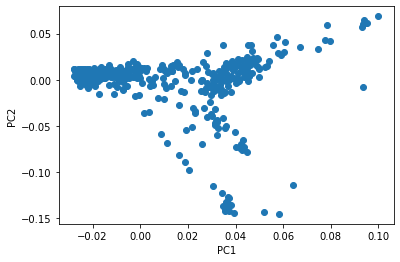

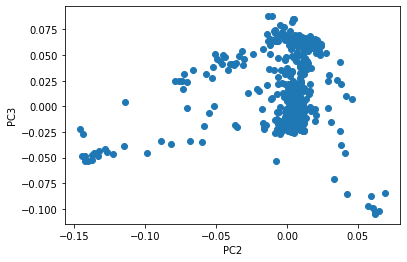

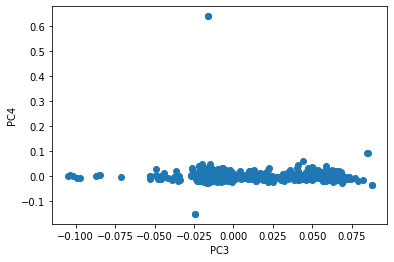

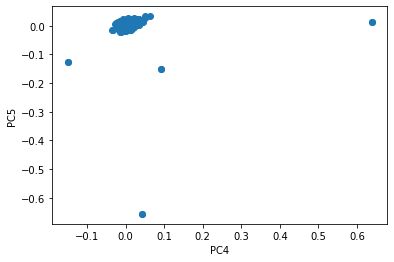

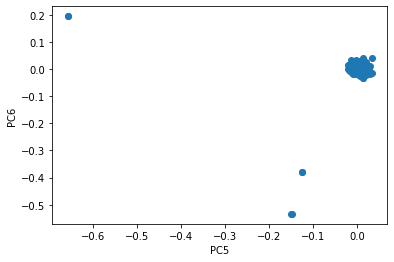

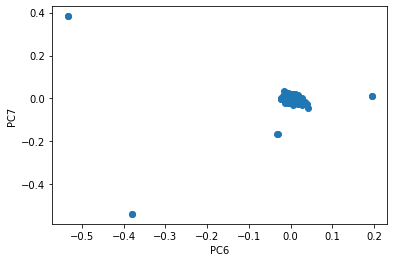

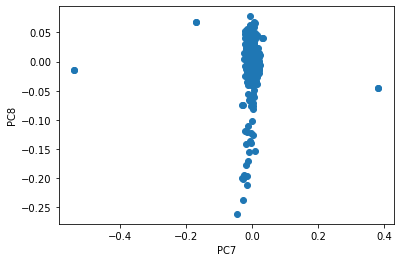

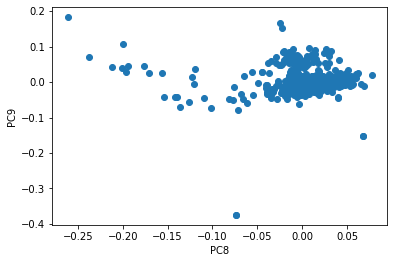

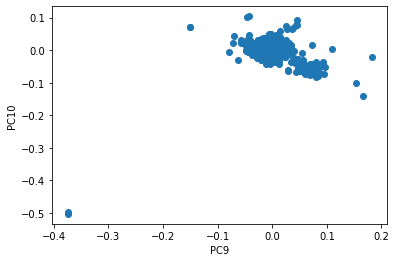

In [134]:
for i in range(1,10):
    pc_a = 'PC' + str(i)
    pc_b = 'PC' + str(i+1)
    plt.scatter(df[pc_a], df[pc_b])
    #plt.title(pc_a+' '+pc_b)
    plt.xlabel(pc_a)
    plt.ylabel(pc_b)
    plt.show()


In [135]:
#Check dataframe after deletion
df

#FID      IID       PC1       PC2       PC3       PC4       PC5  \
0      CB1    Fam-1 -0.014909  0.006447  0.000693 -0.002047 -0.010023   
1      CB2    Fam-2  0.027721 -0.008602  0.071372 -0.009006 -0.019935   
2      CB3    Fam-3 -0.023931  0.004958 -0.018691 -0.021182  0.009501   
3      CB4    Fam-4 -0.023267  0.002992 -0.015557  0.016495  0.011953   
4      CB5    Fam-5 -0.024506  0.009007 -0.009405 -0.011462  0.005782   
..     ...      ...       ...       ...       ...       ...       ...   
755  CB544  Fam-756 -0.020576 -0.001164 -0.010023  0.008744  0.014292   
756  CB650  Fam-757 -0.022458  0.005769 -0.018181  0.001340  0.015629   
757  CB700  Fam-758 -0.022839  0.002699 -0.010471 -0.006983  0.019552   
758  CB750  Fam-759 -0.017725  0.007677  0.000107 -0.012460  0.002250   
759  CB800  Fam-760 -0.023688  0.001924 -0.018576 -0.015508 -0.008179   

          PC6       PC7       PC8  ...      PC11      PC12      PC13  \
0    0.011835  0.014234  0.013951  ... -0.025573 -0.037673 -0.006008   
1   -0.001354 -0.007275 -0.022395  ...  0.007577  0.035710 -0.021339   
2   -0.001340 -0.005662 -0.012752  ... -0.015868  0.000611 -0.012378   
3    0.012751 -0.004964 -0.005455  ... -0.000219  0.037312  0.047661   
4    0.001778  0.004889 -0.001132  ... -0.005790 -0.001212 -0.007823   
..        ...       ...       ...  ...       ...       ...       ...   
755  0.008890  0.008081 -0.005548  ... -0.009061 -0.042418  0.039687   
756 -0.015983  0.006810 -0.000934  ...  0.011413  0.015387 -0.075040   
757  0.005778  0.006069  0.000767  ... -0.009367 -0.012593 -0.023797   
758  0.002850  0.012817  0.004498  ...  0.013298  0.017329 -0.020664   
759  0.008743  0.002599 -0.012896  ... -0.016290 -0.003358 -0.000695   

         PC14      PC15      PC16      PC17      PC18      PC19      PC20  
0    0.037884 -0.004169 -0.050181 -0.031233  0.052004  0.002075  0.025593  
1    0.036330  0.003921 -0.008028  0.042326 -0.040145  0.012089 -0.007630  
2   -0.029400 -0.033606  0.033609  0.021712 -0.039446 -0.066434 -0.002991  
3    0.012059 -0.004969  0.014701 -0.021690  0.005169  0.011773 -0.006894  
4    0.012113  0.033241 -0.007545 -0.028087 -0.027094  0.018094 -0.037591  
..        ...       ...       ...       ...       ...       ...       ...  
755 -0.009111 -0.045261 -0.055304  0.029387  0.040420  0.013246 -0.001050  
756 -0.054694  0.006813 -0.016791  0.000216  0.045443 -0.032296 -0.001699  
757 -0.024775  0.021954  0.037352 -0.048492 -0.025134  0.017816 -0.047514  
758  0.068067  0.036722 -0.013261 -0.002865  0.037736 -0.027365 -0.076091  
759  0.018368 -0.013992  0.024376 -0.017513 -0.003777 -0.043038  0.039259  

[741 rows x 22 columns]

### Get list of deleted samples

In [136]:
#otherwise use current one:
new_df = df

#Load the dataframe from a file if desired
#new_df = pd.read_csv('/home/antton/TFM/PCA_for_GWAS/May26_cleaned_PCA.txt', sep='\t')


In [137]:
#Lists with sample names
samples_after_cleanup = list(new_df['#FID'])
samples_original = list(complete_df['#FID'])

In [138]:
outliers = list(set(samples_original) - set(samples_after_cleanup))
outliers.sort(key=natural_keys)
print(outliers)

['CB22', 'CB43', 'CB95', 'CB124', 'CB161', 'CB244', 'CB268', 'CB279', 'CB308', 'CB456', 'CB478', 'CB503', 'CB562', 'CB578', 'CB600', 'CB685', 'CB722', 'CB788', 'CB793']


### Save results to file and generate MatrixTable

In [151]:
df.to_csv(r'/home/antton/TFM/PCA_for_GWAS/June10_cleaned_PCA.txt',  sep='\t', mode='a')

In [152]:
sample_list_geno = df['#FID'].tolist()
sample_list_geno.sort(key=natural_keys)

In [153]:
#Index merged bgen file
path_to_merged_bgen = '/home/antton/TFM/PCA_for_GWAS/bgens/merged_sorted.bgen'

#Indexing only necessary if index file doens't laready exist
#hl.index_bgen(path_to_merged_bgen)

In [154]:
#Path to sample file
sample_path = '/home/antton/cbio3/data/deCODE-BloodVariome-CordBlood-imputed-(800 samples)-2020/Sweden_CordBlood_wAliases_201130_ID2first.sample'

#Create Hail MatrixTable from BGEN file that was merged in PLINK2
mt2 = hl.import_bgen(path_to_merged_bgen, entry_fields=['GT','GP'], sample_file=sample_path)


2021-06-11 12:13:43 Hail: INFO: Number of BGEN files parsed: 1
2021-06-11 12:13:43 Hail: INFO: Number of samples in BGEN files: 760
2021-06-11 12:13:43 Hail: INFO: Number of variants across all BGEN files: 21580275


In [155]:
variants_total = mt2.count_rows()
print('Samples: %d  Variants: %d' % (mt2.count_cols(), variants_total))

Samples: 760  Variants: 21580275


## GWAS!

First we need to filter the variants. Filtering was done with PLINK already, but I can't figure out a way of outputing the filtered data as a BGEN, so instead we will apply the same filters here on the complete file. 

In [156]:
mt2 = hl.variant_qc(mt2)  # Add row parameter 'variant_qc' to MatrixTable

mt2.row.describe()

--------------------------------------------------------
Type:
        struct {
        locus: locus<GRCh37>, 
        alleles: array<str>, 
        rsid: str, 
        varid: str, 
        variant_qc: struct {
            AC: array<int32>, 
            AF: array<float64>, 
            AN: int32, 
            homozygote_count: array<int32>, 
            call_rate: float64, 
            n_called: int64, 
            n_not_called: int64, 
            n_filtered: int64, 
            n_het: int64, 
            n_non_ref: int64, 
            het_freq_hwe: float64, 
            p_value_hwe: float64
        }
    }
--------------------------------------------------------
Source:
Index:
    ['row']
--------------------------------------------------------


Apply the AF and HWE filters again, since we have all 21 milion variants in the BGEN

In [157]:
mt2 = mt2.filter_rows(mt2.variant_qc.AF[1] > 0.05)
variants_after_AF_filter = mt2.count_rows()


In [158]:
print('Samples: %d  Variants: %d' % (mt2.count_cols(), variants_after_AF_filter))
print('Variants removed by AF filter: ', variants_total-variants_after_AF_filter)

Samples: 760  Variants: 7412543
Variants removed by AF filter:  14167732


In [159]:
##Take only those variants close to HW equilibrium
mt2 = mt2.filter_rows(mt2.variant_qc.p_value_hwe > 1e-6)
variantes_after_HWE_filter = mt2.count_rows()


In [160]:
print('Samples: %d  Variants: %d' % (mt2.count_cols(), variantes_after_HWE_filter))
print('Variants removed by HWE filter: ', variants_after_AF_filter-variantes_after_HWE_filter)

Samples: 760  Variants: 7393293
Variants removed by HWE filter:  19250


## Add phenotype data

In [161]:
phenos_filepath = '/home/antton/TFM/output/aligater_output_test/cblood_test_2021-05-09.txt'

In [162]:
pheno_df = pd.read_table(phenos_filepath, na_values='None')

In [163]:
# Remove samples that are known to have been gated incorrectly
with open('/home/antton/TFM/samples_to_remove_mar24.txt', 'r') as f:
    #Text file contaning names of samples to remove
    samples_to_remove = []
    for line in f:
        samples_to_remove.append('fcs/'+line.rstrip().replace('-','/'))
pheno_df = pheno_df[~pheno_df.sampleName.isin(samples_to_remove)]
print('Removed '+str(len(samples_to_remove))+' incorrectly gated samples')

Removed 74 incorrectly gated samples


In [164]:
#List of phenotypes that we are interested on

selected_phenotype_list = ['CD34+/CD45+',
                           'linneg_cd34pos/CD45+',
                           'HSC_1/CD34+',
                           #'HSC_2/Lin-CD34+',
                           'MPP_1/CD34+',
                           #'MPP_2/Lin-CD34+',
                           'B-NK_1/CD38+',
                           'B-NK_2/CD34+',
                           #'B-NK_3/Lin-CD34+',
                           'CMP_1/CD34+',
                           #'CMP_2/Lin-CD34+',
                           'MEP_1/CD34+']#,
                           #'MEP_2/Lin-CD34+']
    
cleaned_names_dict = {  'CD34+/CD45+': 'CD34+/CD45+',
                        'linneg_cd34pos/CD45+': 'linNegCD34+/CD45+',
                        'HSC_1/CD34+': 'HSC/CD34+',
                        'MPP_1/CD34+': 'MPP/CD34+',
                        'B-NK_1/CD38+': 'B-NK/CD38+',
                        'B-NK_2/CD34+': 'B-NK/CD34+',
                        'CMP_1/CD34+': 'CMP/CD34+',
                        'MEP_1/CD34+': 'MEP/CD34+'
}

In [165]:
#Create and add a 'CBID' column to the DataFrame, then rename the indeces using that column.
CBID_col_middle_step = pheno_df['sampleName'].tolist()
CBID_col = ['CB'+x.split()[-1].split('-')[0] for x in CBID_col_middle_step]
pheno_df.insert(0,'CBID',CBID_col)

#Change axis
pheno_df.set_axis(pheno_df['CBID'].tolist(),axis='rows', inplace=True)

#Get the common sample list between genotype and phenotype
sample_list_pheno = pheno_df.index.tolist()
final_sample_list = list(set(sample_list_pheno).intersection(sample_list_geno))
final_sample_list.sort(key=natural_keys)

pheno_df = pheno_df.loc[final_sample_list]

#Make sub-DataFrame containing only phenotypes of interest
selected_pheno_df = pheno_df[selected_phenotype_list].copy()
selected_pheno_df.rename(mapper=cleaned_names_dict, axis=1, inplace=True)
selected_phenotype_list = [cleaned_names_dict[x] for x in selected_phenotype_list] #Replace list values with cleaned names

In [166]:
selected_pheno_df

CD34+/CD45+  linNegCD34+/CD45+  HSC/CD34+  MPP/CD34+  B-NK/CD38+  \
CB27      0.019324           0.016017   0.086722   0.142531    0.043525   
CB27      0.023918           0.020725   0.068456   0.163609    0.035933   
CB28      0.034297           0.028244   0.080392   0.102293    0.110183   
CB28      0.026698           0.022485   0.069489   0.112496    0.100160   
CB29      0.013049           0.010879   0.065921   0.123457    0.046614   
...            ...                ...        ...        ...         ...   
CB844     0.006384           0.005438   0.047533   0.136609    0.061651   
CB845     0.008644           0.007739   0.066667   0.119949    0.041902   
CB846     0.009536           0.008269   0.078707   0.128367    0.097308   
CB847     0.010996           0.009650   0.131447   0.095238    0.030258   
CB848          NaN                NaN        NaN        NaN         NaN   

       B-NK/CD34+  CMP/CD34+  MEP/CD34+  
CB27     0.025311   0.340041   0.094398  
CB27     0.021924   0.352871   0.107383  
CB28     0.064545   0.302242   0.078717  
CB28     0.060501   0.319320   0.075867  
CB29     0.027254   0.282087   0.081062  
...           ...        ...        ...  
CB844    0.037148   0.296585   0.079089  
CB845    0.026770   0.355212   0.077992  
CB846    0.059264   0.305458   0.078004  
CB847    0.018713   0.383539   0.081546  
CB848         NaN        NaN        NaN  

[837 rows x 8 columns]

In [167]:
def drop_none_na(input_df):
    # Function that drops all 'NaN's in a DataFrame.
    # Also changes contents to float
    input_df = input_df.dropna().copy()
    input_df = input_df.astype(float)
    
    return input_df

In [168]:
#Drop the NA values ONCE WE HAVE DECIDED THE RELEVANT PHENOTYPES
selected_pheno_df = drop_none_na(selected_pheno_df)

#Dealing with duplicates
#The current approach is to just drop the duplicates. The ideal approach would be to calculate the mean.
selected_pheno_df = selected_pheno_df[~selected_pheno_df.index.duplicated(keep='last')].copy()

selected_pheno_df

CD34+/CD45+  linNegCD34+/CD45+  HSC/CD34+  MPP/CD34+  B-NK/CD38+  \
CB27      0.023918           0.020725   0.068456   0.163609    0.035933   
CB28      0.026698           0.022485   0.069489   0.112496    0.100160   
CB29      0.009993           0.008206   0.076084   0.111808    0.042763   
CB30      0.004826           0.004092   0.073039   0.087012    0.041754   
CB31      0.028827           0.022784   0.059595   0.134822    0.025039   
...            ...                ...        ...        ...         ...   
CB843     0.003189           0.002780   0.061264   0.071289    0.070614   
CB844     0.006384           0.005438   0.047533   0.136609    0.061651   
CB845     0.008644           0.007739   0.066667   0.119949    0.041902   
CB846     0.009536           0.008269   0.078707   0.128367    0.097308   
CB847     0.010996           0.009650   0.131447   0.095238    0.030258   

       B-NK/CD34+  CMP/CD34+  MEP/CD34+  
CB27     0.021924   0.352871   0.107383  
CB28     0.060501   0.319320   0.075867  
CB29     0.024816   0.289337   0.094628  
CB30     0.025405   0.364560   0.072404  
CB31     0.013538   0.233426   0.075994  
...           ...        ...        ...  
CB843    0.044834   0.375104   0.049011  
CB844    0.037148   0.296585   0.079089  
CB845    0.026770   0.355212   0.077992  
CB846    0.059264   0.305458   0.078004  
CB847    0.018713   0.383539   0.081546  

[681 rows x 8 columns]

##Exploring quantile normalize
selected_pheno_df.stack()
selected_pheno_df.rank(method='first').stack().astype(int) #Individual ranks per column
selected_pheno_df.stack().groupby(selected_pheno_df.rank(method='first').stack().astype(int)).mean() #rank map

In [169]:
## Quantile normalize!!!

def quantile_normalize(input_df):
    
    normalized_input_df = pd.DataFrame(columns = input_df.columns.tolist())
    rank_mean = input_df.stack().groupby(input_df.rank(method='first').stack().astype(int)).mean()
    normalized_input_df = input_df.rank(method='min').stack().astype(int).map(rank_mean).unstack()
    
    return normalized_input_df

normal_selected_pheno_df = quantile_normalize(selected_pheno_df)
normal_selected_pheno_df

CD34+/CD45+  linNegCD34+/CD45+  HSC/CD34+  MPP/CD34+  B-NK/CD38+  \
CB27      0.120768           0.122935   0.094311   0.107786    0.066928   
CB28      0.130102           0.130655   0.095313   0.076216    0.121916   
CB29      0.087357           0.086305   0.102179   0.075610    0.075646   
CB30      0.064160           0.065460   0.099017   0.065168    0.074635   
CB31      0.133218           0.132151   0.083983   0.088301    0.051431   
...            ...                ...        ...        ...         ...   
CB843     0.051431           0.055360   0.086211   0.058685    0.099757   
CB844     0.073677           0.074571   0.067470   0.089146    0.092161   
CB845     0.081741           0.084150   0.092098   0.080591    0.075029   
CB846     0.085390           0.086557   0.104381   0.084582    0.120768   
CB847     0.090020           0.092231   0.139350   0.068867    0.059786   

       B-NK/CD34+  CMP/CD34+  MEP/CD34+  
CB27     0.068915   0.104915   0.118708  
CB28     0.123283   0.087106   0.085789  
CB29     0.075256   0.073377   0.106601  
CB30     0.076018   0.111949   0.082395  
CB31     0.051534   0.051431   0.085896  
...           ...        ...        ...  
CB843    0.104001   0.119615   0.055360  
CB844    0.093009   0.076630   0.089510  
CB845    0.078284   0.106371   0.088559  
CB846    0.121916   0.080864   0.088642  
CB847    0.063261   0.125842   0.092037  

[681 rows x 8 columns]

In [170]:
import matplotlib.pyplot as plt

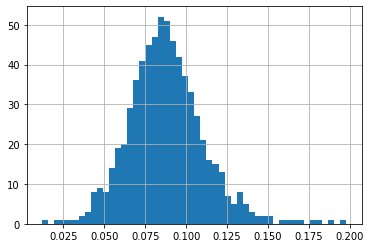

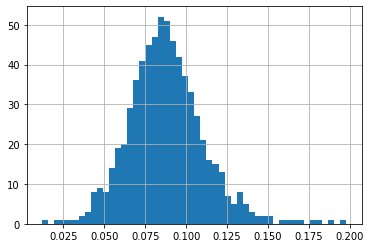

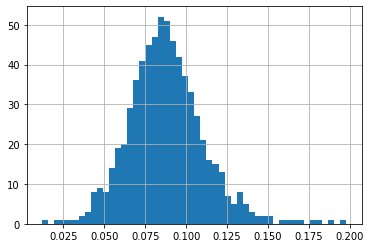

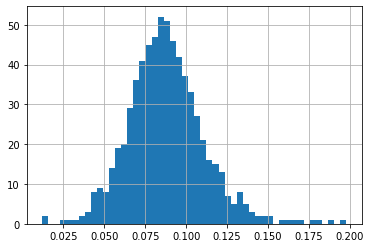

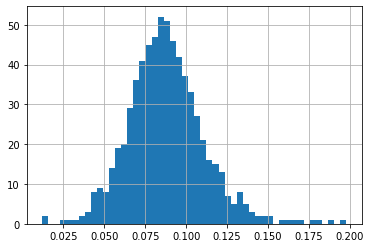

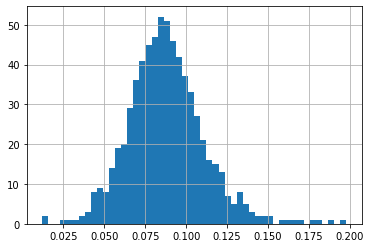

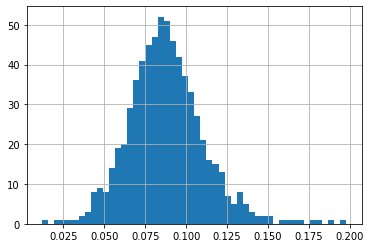

In [172]:
for i in range(7):
    normal_selected_pheno_df[normal_selected_pheno_df.columns.tolist()[i]].hist(bins=50)
    plt.show()


def log_normalize(input_df):
    #Log normalized and (sometimes) median centered!

    normalized_input_df = pd.DataFrame(columns = input_df.columns.tolist())
    normalized_input_df = np.log2(input_df) #- np.log2(input_df).median() #Median centered
    normalized_input_df = normalized_input_df.astype(float).replace([np.inf, -np.inf], np.nan).dropna()
    return normalized_input_df

normal_selected_pheno_df = log_normalize(selected_pheno_df)
normal_selected_pheno_df

In [173]:
final_pheno_df = normal_selected_pheno_df.copy() #Perhaps unnecessary but just to be consistent...
final_pheno_df['sampleName'] = final_pheno_df.index.tolist()

In [174]:
final_pheno_df

CD34+/CD45+  linNegCD34+/CD45+  HSC/CD34+  MPP/CD34+  B-NK/CD38+  \
CB27      0.120768           0.122935   0.094311   0.107786    0.066928   
CB28      0.130102           0.130655   0.095313   0.076216    0.121916   
CB29      0.087357           0.086305   0.102179   0.075610    0.075646   
CB30      0.064160           0.065460   0.099017   0.065168    0.074635   
CB31      0.133218           0.132151   0.083983   0.088301    0.051431   
...            ...                ...        ...        ...         ...   
CB843     0.051431           0.055360   0.086211   0.058685    0.099757   
CB844     0.073677           0.074571   0.067470   0.089146    0.092161   
CB845     0.081741           0.084150   0.092098   0.080591    0.075029   
CB846     0.085390           0.086557   0.104381   0.084582    0.120768   
CB847     0.090020           0.092231   0.139350   0.068867    0.059786   

       B-NK/CD34+  CMP/CD34+  MEP/CD34+ sampleName  
CB27     0.068915   0.104915   0.118708       CB27  
CB28     0.123283   0.087106   0.085789       CB28  
CB29     0.075256   0.073377   0.106601       CB29  
CB30     0.076018   0.111949   0.082395       CB30  
CB31     0.051534   0.051431   0.085896       CB31  
...           ...        ...        ...        ...  
CB843    0.104001   0.119615   0.055360      CB843  
CB844    0.093009   0.076630   0.089510      CB844  
CB845    0.078284   0.106371   0.088559      CB845  
CB846    0.121916   0.080864   0.088642      CB846  
CB847    0.063261   0.125842   0.092037      CB847  

[681 rows x 9 columns]

In [175]:
#Write the normalized data to file to import to Hail later
final_pheno_df.to_csv(r'/home/antton/TFM/GWAS/data/CB_jun11_2021_quantileNormalized.txt',  sep='\t', mode='a')

## Annotation (a.k.a. adding phenotypes to mt2)
Here we will add the phenotype information to the Hail MatrixTable. We will also inclue de Principal Components obtained in PLINK

In [176]:
#Annotate with CD34 alt-gating phenotypes
table = hl.import_table('/home/antton/TFM/GWAS/data/CB_jun11_2021_quantileNormalized.txt', types={'sampleName': hl.tstr},impute=True,delimiter='\t', missing="").key_by('sampleName')
mt2 = mt2.annotate_cols(**table[mt2.s])

2021-06-11 14:01:11 Hail: INFO: Reading table to impute column types
2021-06-11 14:01:12 Hail: INFO: Finished type imputation
  Loading field '' as type str (imputed)
  Loading field 'CD34+/CD45+' as type float64 (imputed)
  Loading field 'linNegCD34+/CD45+' as type float64 (imputed)
  Loading field 'HSC/CD34+' as type float64 (imputed)
  Loading field 'MPP/CD34+' as type float64 (imputed)
  Loading field 'B-NK/CD38+' as type float64 (imputed)
  Loading field 'B-NK/CD34+' as type float64 (imputed)
  Loading field 'CMP/CD34+' as type float64 (imputed)
  Loading field 'MEP/CD34+' as type float64 (imputed)
  Loading field 'sampleName' as type str (user-supplied type)


In [177]:
table = hl.import_table('/home/antton/TFM/PCA_for_GWAS/May26_cleaned_PCA.txt', types={'#FID': hl.tstr},impute=True,delimiter='\t', missing="").key_by('#FID')
mt2 = mt2.annotate_cols(**table[mt2.s])


2021-06-11 14:02:27 Hail: INFO: Reading table to impute column types
2021-06-11 14:02:28 Hail: INFO: Finished type imputation
  Loading field '' as type int32 (imputed)
  Loading field '#FID' as type str (user-supplied type)
  Loading field 'IID' as type str (imputed)
  Loading field 'PC1' as type float64 (imputed)
  Loading field 'PC2' as type float64 (imputed)
  Loading field 'PC3' as type float64 (imputed)
  Loading field 'PC4' as type float64 (imputed)
  Loading field 'PC5' as type float64 (imputed)
  Loading field 'PC6' as type float64 (imputed)
  Loading field 'PC7' as type float64 (imputed)
  Loading field 'PC8' as type float64 (imputed)
  Loading field 'PC9' as type float64 (imputed)
  Loading field 'PC10' as type float64 (imputed)
  Loading field 'PC11' as type float64 (imputed)
  Loading field 'PC12' as type float64 (imputed)
  Loading field 'PC13' as type float64 (imputed)
  Loading field 'PC14' as type float64 (imputed)
  Loading field 'PC15' as type float64 (imputed)
  Loa

In [178]:
#Check annotation is comlpete
mt2.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    '': int32
    'CD34+/CD45+': float64
    'linNegCD34+/CD45+': float64
    'HSC/CD34+': float64
    'MPP/CD34+': float64
    'B-NK/CD38+': float64
    'B-NK/CD34+': float64
    'CMP/CD34+': float64
    'MEP/CD34+': float64
    'IID': str
    'PC1': float64
    'PC2': float64
    'PC3': float64
    'PC4': float64
    'PC5': float64
    'PC6': float64
    'PC7': float64
    'PC8': float64
    'PC9': float64
    'PC10': float64
    'PC11': float64
    'PC12': float64
    'PC13': float64
    'PC14': float64
    'PC15': float64
    'PC16': float64
    'PC17': float64
    'PC18': float64
    'PC19': float64
    'PC20': float64
----------------------------------------
Row fields:
    'locus': locus<GRCh37>
    'alleles': array<str>
    'rsid': str
    'varid': str
    'variant_qc': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: 

## Do GWAS
Now that we have all of the phenotype data loaded into the MatrixTable, as well as the principal components from the PCA, we can carry out the actual GWAS. We do this by using the Hail method 'linear_regression_rows'.

In [179]:
for phenotype in selected_phenotype_list:
    print(phenotype)
    gwas = hl.linear_regression_rows(y=mt2[phenotype], x=mt2.GT.n_alt_alleles(), covariates=[1.0,mt2.PC1,mt2.PC2,mt2.PC3,mt2.PC4,mt2.PC5,mt2.PC6,mt2.PC7,mt2.PC8,mt2.PC9,mt2.PC10], pass_through=[mt2.rsid])
    gwas = gwas.key_by('rsid')
    results=gwas.select(chromosome = gwas.locus.contig, position=gwas.locus.position, A1 = gwas.alleles[0], A2 = gwas.alleles[1], pval = gwas.p_value, beta = gwas.beta, tstat = gwas.t_stat, n=gwas.n)
    pathStr="/home/antton/TFM/GWAS/output/May27_2021/CB_May27_"+phenotype.replace("/","-")+".txt"
    results.export(pathStr,header=True)

CD34+/CD45+


2021-06-11 14:02:58 Hail: WARN: 85 of 760 samples have a missing phenotype or covariate.
2021-06-11 14:02:58 Hail: INFO: linear_regression_rows: running on 675 samples for 1 response variable y,
    with input variable x, and 11 additional covariates...
2021-06-11 14:08:02 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-06-11 14:08:50 Hail: INFO: merging 53 files totalling 550.2M...
2021-06-11 14:08:51 Hail: INFO: while writing:
    /home/antton/TFM/GWAS/output/May27_2021/CB_May27_CD34+-CD45+.txt
  merge time: 1.286s


linNegCD34+/CD45+


2021-06-11 14:08:57 Hail: WARN: 85 of 760 samples have a missing phenotype or covariate.
2021-06-11 14:08:57 Hail: INFO: linear_regression_rows: running on 675 samples for 1 response variable y,
    with input variable x, and 11 additional covariates...
2021-06-11 14:13:46 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-06-11 14:14:26 Hail: INFO: merging 53 files totalling 550.2M...
2021-06-11 14:14:27 Hail: INFO: while writing:
    /home/antton/TFM/GWAS/output/May27_2021/CB_May27_linNegCD34+-CD45+.txt
  merge time: 1.111s


HSC/CD34+


2021-06-11 14:14:32 Hail: WARN: 85 of 760 samples have a missing phenotype or covariate.
2021-06-11 14:14:32 Hail: INFO: linear_regression_rows: running on 675 samples for 1 response variable y,
    with input variable x, and 11 additional covariates...
2021-06-11 14:19:16 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-06-11 14:19:54 Hail: INFO: merging 53 files totalling 550.2M...
2021-06-11 14:19:55 Hail: INFO: while writing:
    /home/antton/TFM/GWAS/output/May27_2021/CB_May27_HSC-CD34+.txt
  merge time: 1.107s


MPP/CD34+


2021-06-11 14:19:58 Hail: WARN: 85 of 760 samples have a missing phenotype or covariate.
2021-06-11 14:19:58 Hail: INFO: linear_regression_rows: running on 675 samples for 1 response variable y,
    with input variable x, and 11 additional covariates...
2021-06-11 14:24:44 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-06-11 14:25:23 Hail: INFO: merging 53 files totalling 550.1M...
2021-06-11 14:25:24 Hail: INFO: while writing:
    /home/antton/TFM/GWAS/output/May27_2021/CB_May27_MPP-CD34+.txt
  merge time: 1.195s


B-NK/CD38+


2021-06-11 14:25:29 Hail: WARN: 85 of 760 samples have a missing phenotype or covariate.
2021-06-11 14:25:29 Hail: INFO: linear_regression_rows: running on 675 samples for 1 response variable y,
    with input variable x, and 11 additional covariates...
2021-06-11 14:30:14 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-06-11 14:30:54 Hail: INFO: merging 53 files totalling 550.2M...
2021-06-11 14:30:55 Hail: INFO: while writing:
    /home/antton/TFM/GWAS/output/May27_2021/CB_May27_B-NK-CD38+.txt
  merge time: 1.530s


B-NK/CD34+


2021-06-11 14:31:00 Hail: WARN: 85 of 760 samples have a missing phenotype or covariate.
2021-06-11 14:31:00 Hail: INFO: linear_regression_rows: running on 675 samples for 1 response variable y,
    with input variable x, and 11 additional covariates...
2021-06-11 14:35:58 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-06-11 14:36:41 Hail: INFO: merging 53 files totalling 550.2M...
2021-06-11 14:36:42 Hail: INFO: while writing:
    /home/antton/TFM/GWAS/output/May27_2021/CB_May27_B-NK-CD34+.txt
  merge time: 1.783s


CMP/CD34+


2021-06-11 14:36:49 Hail: WARN: 85 of 760 samples have a missing phenotype or covariate.
2021-06-11 14:36:49 Hail: INFO: linear_regression_rows: running on 675 samples for 1 response variable y,
    with input variable x, and 11 additional covariates...
2021-06-11 14:41:53 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-06-11 14:42:36 Hail: INFO: merging 53 files totalling 550.2M...
2021-06-11 14:42:40 Hail: INFO: while writing:
    /home/antton/TFM/GWAS/output/May27_2021/CB_May27_CMP-CD34+.txt
  merge time: 4.018s


MEP/CD34+


2021-06-11 14:42:45 Hail: WARN: 85 of 760 samples have a missing phenotype or covariate.
2021-06-11 14:42:45 Hail: INFO: linear_regression_rows: running on 675 samples for 1 response variable y,
    with input variable x, and 11 additional covariates...
2021-06-11 14:47:38 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-06-11 14:48:20 Hail: INFO: merging 53 files totalling 550.2M...
2021-06-11 14:48:35 Hail: INFO: while writing:
    /home/antton/TFM/GWAS/output/May27_2021/CB_May27_MEP-CD34+.txt
  merge time: 14.369s


In [180]:
#Show Manhattan plot for the last of the phenotypes
p = hl.plot.manhattan(gwas.p_value)
show(p)



In [181]:
#Show Q-Q plot for the last of the phenotypes
p = hl.plot.qq(gwas.p_value)
show(p)



2021-06-11 14:51:46 Hail: INFO: Ordering unsorted dataset with network shuffle


In [85]:
#Check the 'gwas' matrix table
gwas.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'locus': locus<GRCh37> 
    'alleles': array<str> 
    'rsid': str 
    'n': int32 
    'sum_x': float64 
    'y_transpose_x': float64 
    'beta': float64 
    'standard_error': float64 
    't_stat': float64 
    'p_value': float64 
----------------------------------------
Key: ['rsid']
----------------------------------------


In [395]:
print(hl.citation())

Hail Team. Hail 0.2.60-de1845e1c2f6. https://github.com/hail-is/hail/commit/de1845e1c2f6.
